---
title: Auditing Bias
author: Omar Armbruster
date: '2025-03-12'
image: "images.jpg"
description: Analyzing Implicit Bias in Machine Learning Models
format: html
execute:
    message: false
    warning: false
---

# Introduction
Machine learning models show potential to revolutionize automated decision-making processes and have already made their way into many of our daily lives through technologies like personalized recommendations, face identification, and self-driving cars. However, these models can also pose extreme dangers, as the models are only as good as the data they are trained on and can very easily reinforce existing injustices in our society. Even when certain traits like race are omitted from the training process, models can predict these traits from other features and still reinforce societal norms that we are trying to avoid. We demonstrate this by training a Decision Tree Classifier model on a dataset of responses to the 2018 Public Use Microdata Sample survey in New York and use it to predict whether an individual is likely to employed. We omit race from our training features and then audit our model to determine if it is truly independent from race. We examine three methods of fairness: calibration, error rate balance, and statistical parity, as well as examine feasible false negative and false positive rates.

We begin by importing the folktables package, which we use to import our data. We specify that we are examining responses from 2018 in the state of New York when fetching our data.

In [116]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "NY"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000012,2,1,3802,1,36,1013097,145,26,...,146,146,21,24,266,263,21,146,265,144
1,P,2018GQ0000040,2,1,2702,1,36,1013097,43,21,...,6,42,43,7,40,6,43,40,42,6
2,P,2018GQ0000060,2,1,2001,1,36,1013097,88,18,...,88,163,161,162,87,12,162,88,87,88
3,P,2018GQ0000081,2,1,2401,1,36,1013097,109,85,...,17,15,111,107,17,196,109,200,198,111
4,P,2018GQ0000103,2,1,1400,1,36,1013097,83,19,...,81,12,80,154,12,80,12,83,152,154


For the sake of simplicity, we can select specific features to train our model on. We select the following:

* AGEP - Age
* SCHL - Educational attainment
* MAR - Marital status
* RELP - Relationship to reference person
* DIS - Disability 
* ESP - Employment status of parents
* CIT - Citizenship stats
* MIG - Mobility status
* MIL - Military service
* ANC - Ancestry
* NATIVITY - Nativity 
* DEAR - Hearing difficulty
* DEYE - Vision difficulty
* DREM - Cognitive difficulty
* SEX - Sex
* RAC1P - Race
* ESR - Employment status 

In [117]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,26,21.0,5,17,2,NaN,5,1.0,4.0,1,2,2,2,2.0,2,1,6.0
1,21,20.0,5,17,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,1,1.0
2,18,16.0,5,17,2,NaN,2,3.0,4.0,1,1,2,2,2.0,2,8,6.0
3,85,16.0,2,16,1,NaN,1,1.0,4.0,4,1,1,2,1.0,2,1,6.0
4,19,19.0,5,17,2,NaN,1,1.0,4.0,2,1,2,2,2.0,2,1,1.0


We use the selected features to define our training dataset but exclude employment status (the target variable) and race, which we claim the model will be able to implicitly determine. We define a problem, which specifies our target and hidden features (employment and race).

Looking briefly at our data, it appears we have $196,967$ observations (people) measured with $15$ features. We confirm that our created feature, label, and group objects all have the same length, as each entry should correspond to a single person.

In [118]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

for obj in [features, label, group]:
  print(obj.shape)

(196967, 15)
(196967,)
(196967,)


As is good machine learning practice, we define a testing and training dataset so we can later evaluate how our model performs on unseen data.

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

For later analysis, we create a function that modifies our training and testing datasets, which only include the training features. We add both the group (race) and label (employment status) columns to the new dataset as well as modify encoded labels to labels that we can understand. For the sake of analyzing sufficiently large racial groups, we sort groups into White, African American, Asian, and Other.

In [120]:
import pandas as pd
def format_data(df, features_to_use, group, labels):
    new_df = pd.DataFrame(df, columns = features_to_use)
    new_df['group'] = group
    new_df['employed'] = labels
    new_df['SEX'] = new_df['SEX'].replace({1.0: 'Male', 2.0: 'Female'})
    new_df['group'] = new_df['group'].replace({1.0: 'White', 
                                               2.0: 'African American',
                                               3.0: 'Other Race',
                                               4.0: 'Other Race',
                                               5.0: 'Other Race',
                                               6.0: 'Asian',
                                               7.0: 'Other Race',
                                               8.0: 'Other Race',
                                               9.0: 'Other Race'})

    return new_df

A quick examination of the training data shows that each of our racial groups are in the same order of magnitude with the exception of the White group, which has significantly more people in it.

In [121]:
df_train = format_data(X_train, features_to_use, group_train, y_train)
df_train.groupby('group').size()

group
African American     19200
Asian                13633
Other Race           13904
White               110836
dtype: int64

Using this dataframe, we can determine the population of the training dataset, which we find to be $157,573$ people.

In [147]:
population = df_train.shape[0]
population

157573

Of these individuals, roughly $46.4\%$ people are employed. This rate is likely so low because we included children in our data, the majority of whom are unemployed.

In [123]:
df_train['employed'].mean()

0.4649400595279648

We can also analyze the proportion of each race in our population. As we saw in the population counts above, African Americans, Asians, and Other Racial groups each make up a similar amount of the population with $11.0\%$, $9.3\%$, and $7.9\%$ respectively, while White people make up the remaining $71.8\%$ of the population.

In [124]:
df_train[df_train['employed'] == 1].groupby('group').size()/df_train[df_train['employed'] == 1].shape[0]

group
African American    0.109607
Asian               0.092517
Other Race          0.079277
White               0.718599
dtype: float64

Despite variances in the size of each racial group, we observe roughly equal employment rates across groups such that $41.8\%$ of African Americans are employed, $49.7\%$ of Asians are employed, $47/5\%$ of Whites are employed, and $41.8\%$ of individuals in other racial groups are employed. These values will be important later for when we audit our model to determine how consistent the predicted employment rates are with reality.

In [125]:
df_train.groupby('group')['employed'].mean()

group
African American    0.418229
Asian               0.497176
Other Race          0.417722
White               0.474990
Name: employed, dtype: float64

It is also worth checking for intersectional trends by breaking down the proportion of people employed by sex as well as race. This can help us determine if race is the major factor in disparities between groups or if there are other contributing factors within racials groups. Based on our bar plot below, women and men tend to make up roughly similar proportions of the workforce within their race, indicating that there is not a signficant difference in employment by sex like there is with race (with Whites making up the largest portion of the workforce).

[Text(0.5, 1.0, 'Workforce Composition')]

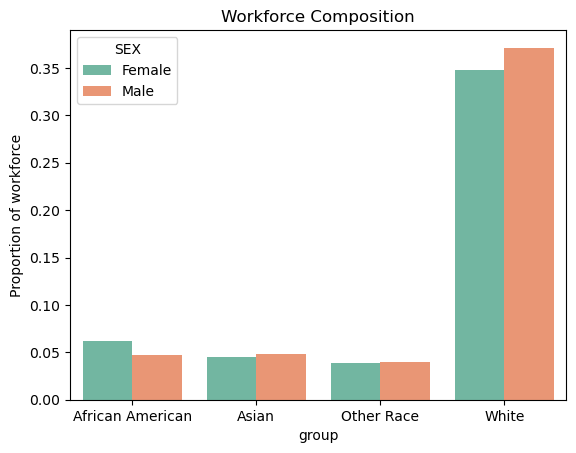

In [126]:
import seaborn as sns
import seaborn.objects as so

prop = (df_train[df_train['employed'] == 1].groupby(['group', 'SEX']).size()/df_train[df_train['employed'] == 1].shape[0]).reset_index(name = 'Proportion of workforce')
p1 = sns.barplot(data = prop,
                 x = 'group',
                 y = 'Proportion of workforce',
                 hue = 'SEX',
                 palette='Set2')
p1.set(title = 'Workforce Composition')

Now to train our model. We have chosen to use a Decision Tree Classifer Model. We use the Standard Scaler to make sure each of our features are weighted equally when training our model.

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [128]:
max_depths = np.linspace(1, 100, 100)
best_depth = 1
best_val = 0
best_model = DecisionTreeClassifier(max_depth = 1)
for depth in max_depths:
    DTC = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth = int(depth)))
    DTC.fit(X_train, y_train)
    val = cross_val_score(DTC, X_train, y_train, cv = 5).mean()
    if val > best_val:
        best_val = val
        best_depth = depth
        best_model = DTC
print("Best Depth: {}".format(best_depth))




Best Depth: 10.0


# Auditing the model

In [129]:
df = format_data(X_test, features_to_use, group_test, y_test)
df['pred_employed'] = best_model.predict(X_test)
df['correct_prediction'] = (df['employed'] == df['pred_employed'])
df['correct_prediction'].mean()

0.8236787328019496

In [130]:
df['TN'] = (df['employed'] == 0) & (df['pred_employed'] == 0)
df['TP'] = (df['employed'] == 1) & (df['pred_employed'] == 1)
df['FN'] = (df['employed'] == 1) & (df['pred_employed'] == 0)
df['FP'] = (df['employed'] == 0) & (df['pred_employed'] == 1)
df[['TN', 'TP', 'FN', 'FP']].sum()

TN    16713
TP    15735
FN     2472
FP     4474
dtype: int64

In [131]:
PPV = df['TP'].sum() / (df['TP'].sum() + df['FP'].sum())
FPR = df['FP'].sum()/(df['FP'].sum() + df['TN'].sum())
FNR = df['FN'].sum()/(df['FN'].sum() + df['TP'].sum())
print(PPV, FPR, FNR)

0.7786134890395369 0.2111672251852551 0.13577195584116


In [132]:
df.groupby("group")['correct_prediction'].mean()

group
African American    0.820481
Asian               0.795996
Other Race          0.830835
White               0.826724
Name: correct_prediction, dtype: float64

In [133]:
df.groupby('group')[['TP', 'TN', 'FP', 'FN']].sum()

,TP,TN,FP,FN
group,,,,
African American,1800,2158,576,290
Asian,1539,1165,537,156
Other Race,1290,1647,403,195
White,11106,11743,2958,1831


In [134]:
PPV = df.groupby('group')['TP'].sum() / (df.groupby('group')['TP'].sum() + df.groupby('group')['FP'].sum())
PPV

group
African American    0.757576
Asian               0.741329
Other Race          0.761961
White               0.789676
dtype: float64

In [135]:
FPR = df.groupby('group')['FP'].sum()/(df.groupby('group')['FP'].sum() + df.groupby('group')['TN'].sum())
FPR

group
African American    0.210680
Asian               0.315511
Other Race          0.196585
White               0.201211
dtype: float64

In [136]:
FNR = df.groupby('group')['FN'].sum()/(df.groupby('group')['FN'].sum() + df.groupby('group')['TP'].sum())
FNR

group
African American    0.138756
Asian               0.092035
Other Race          0.131313
White               0.141532
dtype: float64

In [137]:
# Calibration
employed = df.groupby('group')['employed'].mean()
predicted_employed = df.groupby('group')['pred_employed'].mean()
pd.concat((predicted_employed, employed), axis = 1, keys = ['Prediction', 'True Rate'])

,Prediction,True Rate
group,,
African American,0.492537,0.433250
Asian,0.611127,0.498970
Other Race,0.478925,0.420085
White,0.508865,0.468087


In [138]:
# Error Rate Parity
pd.concat((FPR, FNR), axis = 1, keys = ['FPR', 'FNR'])

,FPR,FNR
group,,
African American,0.210680,0.138756
Asian,0.315511,0.092035
Other Race,0.196585,0.131313
White,0.201211,0.141532


In [139]:
# Statistical Parity 
df.groupby('group')['pred_employed'].mean()

group
African American    0.492537
Asian               0.611127
Other Race          0.478925
White               0.508865
Name: pred_employed, dtype: float64

In [140]:
import matplotlib.pyplot as plt

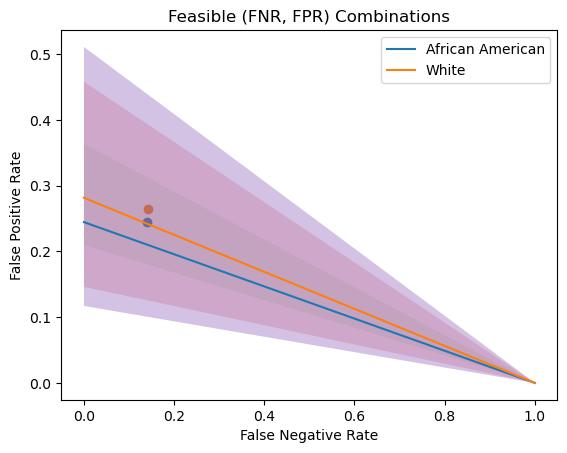

In [146]:
PPV_min = PPV[['African American', 'White']].min()
p = df.groupby('group')['employed'].mean()
FNR_calc = np.linspace(0, 1, 50)
FPR_calc = lambda p,FNR, PPV_min: (p/(1-p)) * ((1 - PPV_min)/PPV_min)*(1 - FNR)
FPRs = [FPR_calc(ps, FNR_calc, PPV_min) for ps in p]
for i, FPR in enumerate(FPRs):
    if(p.index[i] in ['African American', 'White']):
        plt.plot(FNR_calc, FPR, label = p.index[i])
        plt.scatter(FNR[i], FPR[i])
plt.fill_between(FNR_calc, FPR_calc(p['White'], FNR_calc, PPV_min -0.05),FPR_calc(p['White'], FNR_calc, PPV_min +0.05), alpha = 0.1)
plt.fill_between(FNR_calc, FPR_calc(p['White'], FNR_calc, PPV_min -0.1),FPR_calc(p['White'], FNR_calc, PPV_min +0.1), alpha = 0.2)
plt.fill_between(FNR_calc, FPR_calc(p['White'], FNR_calc, PPV_min -0.125),FPR_calc(p['White'], FNR_calc, PPV_min +0.125), alpha = 0.4)
plt.xlabel('False Negative Rate')
plt.ylabel('False Positive Rate')
plt.title('Feasible (FNR, FPR) Combinations')
plt.legend()

# Conclusion
1. 
2. 
3. 
4. 